In [6]:
import math
import heapq
import matplotlib.pyplot as plt

def pi_2_pi(angle):
    while angle > math.pi:
        angle -= 2.0 * math.pi
    while angle <= -math.pi:
        angle += 2.0 * math.pi
    return angle

def angle_degrees(a):
    deg = math.degrees(pi_2_pi(a))
    if deg > 180:
        deg -= 360
    return deg

def dist(a, b):
    return math.hypot(b[0] - a[0], b[1] - a[1])


In [2]:

class HybridAStar:

    def __init__(
        self, 
        grid_w, 
        grid_h, 
        obstacles, 
        n_theta=72,           
        step_size=3.0,        # each motion is 3 cm
        min_turn_radius=10.0, # in cm
        reverse_ok=True,
        goal_tol_xy=2.0,
        goal_tol_yaw_deg=5.0
    ):
        self.w = grid_w
        self.h = grid_h
        self.obstacles = obstacles
        self.n_theta = n_theta
        self.step_size = step_size
        self.min_turn_radius = min_turn_radius
        self.reverse_ok = reverse_ok
        self.goal_tol_xy = goal_tol_xy
        self.goal_tol_yaw = math.radians(goal_tol_yaw_deg)
        self.motion_primitives = self._create_motion_primitives()

    def _create_motion_primitives(self):
        motions = []
        for deg in [0, 15, -15, 30, -30]:
            for direction in (1, -1):
                if direction == -1 and not self.reverse_ok:
                    continue
                motions.append((math.radians(deg), direction))
        return motions

    def _theta_index(self, theta):
        t = pi_2_pi(theta)
        if t < 0:
            t += 2 * math.pi
        frac = t / (2*math.pi)
        return int(round(frac * self.n_theta)) % self.n_theta

    def _collision_check(self, px, py):
        for x, y in zip(px, py):
            ix, iy = round(x), round(y)
            if ix < 0 or ix >= self.w or iy < 0 or iy >= self.h:
                return True
            if (ix, iy) in self.obstacles:
                return True
        return False

    def _motion_step(self, x, y, yaw, turn_rad, direction):
        step_len = self.step_size
        sub_steps = int(step_len) 
        px, py, pyaw = [], [], []

        if abs(turn_rad) < 1e-9:
            # Straight
            dsign = 1.0 if direction>0 else -1.0
            for _ in range(sub_steps):
                x += dsign*math.cos(yaw)
                y += dsign*math.sin(yaw)
                px.append(x)
                py.append(y)
                pyaw.append(yaw)
            return x, y, yaw, px, py, pyaw

        # Arc
        R = self.min_turn_radius
        alpha = (step_len / R) * (1.0 if direction>0 else -1.0)
        alpha_inc = alpha / sub_steps
        for _ in range(sub_steps):
            yaw_mid = yaw + alpha_inc/2.0
            x += R * alpha_inc * math.cos(yaw_mid)
            y += R * alpha_inc * math.sin(yaw_mid)
            yaw = pi_2_pi(yaw + alpha_inc)
            px.append(x)
            py.append(y)
            pyaw.append(yaw)

        return x, y, yaw, px, py, pyaw

    def search(self, sx, sy, syaw, gx, gy, gyaw):
        start_thi = self._theta_index(syaw)
        goal_thi  = self._theta_index(gyaw)

        def heuristic(cx, cy):
            return math.hypot(cx - gx, cy - gy)


        g_cost = {}
        parent = {}
        start_node = (round(sx), round(sy), start_thi)
        g_cost[start_node] = 0.0

        open_set = []
        heapq.heappush(open_set, (heuristic(sx, sy), 0.0, start_node))

        while open_set:
            f_val, c_val, node = heapq.heappop(open_set)
            cx, cy, cthi = node


            if math.hypot(cx - gx, cy - gy) < self.goal_tol_xy:
                ctheta = (cthi * 2 * math.pi) / self.n_theta
                yaw_diff = abs(pi_2_pi(ctheta - gyaw))
                if yaw_diff < self.goal_tol_yaw:
                    return self._reconstruct_path(parent, node, (sx, sy, syaw))

            ctheta = (cthi*2*math.pi)/self.n_theta
            for (turn_rad, direction) in self.motion_primitives:
                nx, ny, nyaw, px_list, py_list, pyaw_list = self._motion_step(
                    cx, cy, ctheta, turn_rad, direction
                )

                if self._collision_check(px_list, py_list):
                    continue

                nthi = self._theta_index(nyaw)
                new_node = (round(nx), round(ny), nthi)
                new_cost = c_val + self.step_size

                if new_node not in g_cost or new_cost < g_cost[new_node]:
                    g_cost[new_node] = new_cost
                    parent[new_node] = (node, px_list, py_list, pyaw_list)
                    f_score = new_cost + heuristic(nx, ny)
                    heapq.heappush(open_set, (f_score, new_cost, new_node))

        return None  

    def _reconstruct_path(self, parent, goal_node, start_pose):
        px, py, pyaw = [], [], []
        node = goal_node
        while node in parent:
            pn, segx, segy, segyaw = parent[node]
            px.extend(reversed(segx))
            py.extend(reversed(segy))
            pyaw.extend(reversed(segyaw))
            node = pn

        px.append(node[0])
        py.append(node[1])
        cth = (node[2] * 2.0*math.pi)/self.n_theta
        pyaw.append(cth)

        px.reverse()
        py.reverse()
        pyaw.reverse()

        px[0] = start_pose[0]
        py[0] = start_pose[1]
        pyaw[0] = start_pose[2]

        return (px, py, pyaw)

def snap_final_orientation(px, py, pyaw, gx, gy, gyaw, obstacles, w, h):

    fx, fy, fyaw = px[-1], py[-1], pyaw[-1]
    if math.hypot(fx - gx, fy - gy) > 2.0:
        return px, py, pyaw

    yaw_diff = pi_2_pi(gyaw - fyaw)
    deg_diff = abs(math.degrees(yaw_diff))
    if deg_diff < 2.0:
        return px, py, pyaw  

    sign = 1.0 if yaw_diff>0 else -1.0
    steps = int(deg_diff)
    tmp_px, tmp_py, tmp_pyaw = [], [], []
    x, y, yaw = fx, fy, fyaw
    for _ in range(steps):
        alpha = math.radians(1.0)*sign
        R = 0.0001 
        yaw_mid = yaw + alpha/2.0
        x += R*alpha*math.cos(yaw_mid)
        y += R*alpha*math.sin(yaw_mid)
        yaw = pi_2_pi(yaw + alpha)
        tmp_px.append(x)
        tmp_py.append(y)
        tmp_pyaw.append(yaw)

    for xx, yy in zip(tmp_px, tmp_py):
        ix, iy = round(xx), round(yy)
        if ix<0 or ix>=w or iy<0 or iy>=h:
            return px, py, pyaw
        if (ix, iy) in obstacles:
            return px, py, pyaw

    px.extend(tmp_px)
    py.extend(tmp_py)
    pyaw.extend(tmp_pyaw)
    return px, py, pyaw

In [3]:

class RobotPathfinding3D:
    def __init__(
        self, 
        grid_size=(200,200),
        start_pose=(0,0,0.0),
        images=None,
        user_obstacles=None,
        min_turn_radius=10.0,
        step_size=3.0
    ):
        if images is None:
            images=[]
        if user_obstacles is None:
            user_obstacles=set()

        self.grid_size = grid_size
        self.start_pose = start_pose
        self.images = images
        self.obstacles = set(user_obstacles)
        self.min_turn_radius = min_turn_radius
        self.step_size = step_size

        self._setup_image_obstacles(radius=15)

        w,h = grid_size
        self.planner = HybridAStar(
            grid_w=w,
            grid_h=h,
            obstacles=self.obstacles,
            n_theta=72,  # 5° increments
            step_size=step_size,
            min_turn_radius=min_turn_radius,
            reverse_ok=True,
            goal_tol_xy=2.0,
            goal_tol_yaw_deg=5.0
        )
        self.path = []

    def _setup_image_obstacles(self, radius=15):
        for (img_coord, _) in self.images:
            ix, iy = img_coord
            for dx in range(-radius, radius+1):
                for dy in range(-radius, radius+1):
                    if math.hypot(dx,dy)<radius:
                        ox, oy = ix+dx, iy+dy
                        if 0<=ox<self.grid_size[0] and 0<=oy<self.grid_size[1]:
                            self.obstacles.add((ox,oy))

    def approach_pose(self, img_coord, direction, dist=20):
        x_img, y_img = img_coord
        if direction=='N':
            return (x_img, y_img-dist, math.pi/2)
        elif direction=='E':
            return (x_img-dist, y_img, 0.0)
        elif direction=='S':
            return (x_img, y_img+dist, -math.pi/2)
        elif direction=='W':
            return (x_img+dist, y_img, math.pi)
        return (x_img, y_img, 0.0)

    def visit_images_in_order(self):
        w,h = self.grid_size
        current_pose = self.start_pose
        path_poses = [current_pose]

        for (img_coord, direction) in self.images:
            gx,gy,gyaw = self.approach_pose(img_coord,direction,dist=20)
            result = self.planner.search(current_pose[0], current_pose[1], current_pose[2],
                                         gx, gy, gyaw)
            if result is None:
                print(f"Cannot reach image {img_coord} from {current_pose}; skipping.")
                continue
            px, py, pyaw = result
            px, py, pyaw = snap_final_orientation(px, py, pyaw, gx, gy, gyaw,
                                                  obstacles=self.obstacles, w=w, h=h)
            seg = [(px[i], py[i], pyaw[i]) for i in range(len(px))]
            path_poses.extend(seg[1:])
            current_pose = path_poses[-1]

        sx, sy, syaw = self.start_pose
        if (abs(current_pose[0]-sx)>1e-9 or
            abs(current_pose[1]-sy)>1e-9 or
            abs(pi_2_pi(current_pose[2]-syaw))>1e-3):
            back = self.planner.search(current_pose[0], current_pose[1], current_pose[2],
                                       sx, sy, syaw)
            if back is not None:
                bpx, bpy, bpyaw = back
                bpx, bpy, bpyaw = snap_final_orientation(bpx,bpy,bpyaw,sx,sy,syaw,
                                                         obstacles=self.obstacles, w=w, h=h)
                seg2 = [(bpx[i], bpy[i], bpyaw[i]) for i in range(len(bpx))]
                path_poses.extend(seg2[1:])
            else:
                print(f"Cannot return from {current_pose} to start.")

        self.path = path_poses
        return self.path

    def plot_path(self):
        if not self.path:
            print("No path or empty path found.")
            return

        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_title("Hybrid A* Path (No Smoothing)")

        if self.obstacles:
            ox, oy = zip(*self.obstacles)
            ax.scatter(ox, oy, c='red', s=5, label="Obstacles")

        for i, ((ix, iy), d) in enumerate(self.images):
            if i==0:
                ax.scatter(ix, iy, c='blue', s=50, marker='s', label="Images")
            else:
                ax.scatter(ix, iy, c='blue', s=50, marker='s')
            ax.text(ix+1, iy+1, d, color='blue', fontsize=8)

        px = [p[0] for p in self.path]
        py = [p[1] for p in self.path]
        ax.plot(px, py, '-g', label="Path")

        sx, sy, syaw = self.start_pose
        ax.scatter(sx, sy, c='black', s=50, label="Start/End")

        ax.set_xlim(0, self.grid_size[0])
        ax.set_ylim(0, self.grid_size[1])
        ax.set_aspect('equal')
        ax.legend()
        ax.grid(True)
        plt.show()




Path length: 527


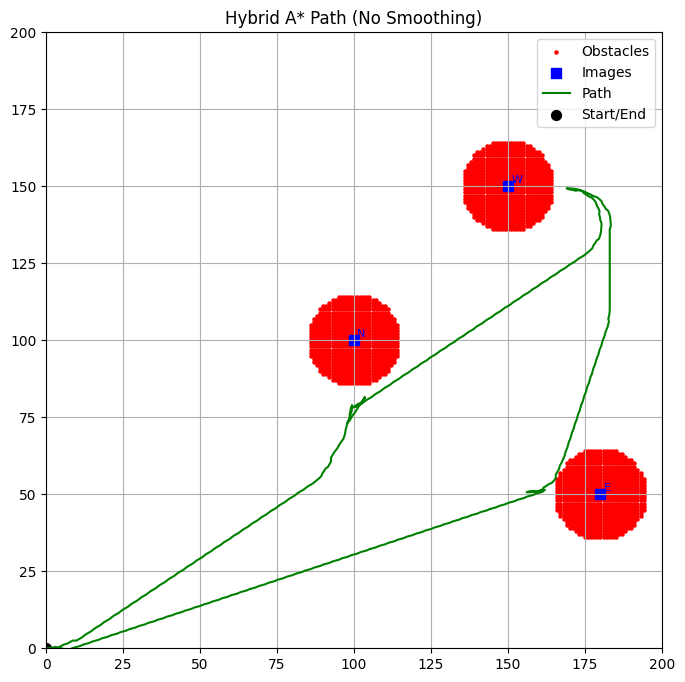

In [4]:

grid_size = (200, 200)
start_pose = (0, 0, 0.0)
images = [
    ((100, 100), 'N'),
    ((150, 150), 'W'),
    ((180, 50),  'E')
]
user_obstacles = {
}

robot = RobotPathfinding3D(
    grid_size=grid_size,
    start_pose=start_pose,
    images=images,
    user_obstacles=user_obstacles,
    min_turn_radius=10.0,
    step_size=3.0
)

path = robot.visit_images_in_order()
print("Path length:", len(path))
robot.plot_path()

TURN 0.1000 radians
MOVE 1.0000 units
TURN 0.1000 radians
MOVE 1.0000 units
TURN 0.1000 radians
MOVE 1.0000 units
TURN 0.0618 radians
MOVE 1.0052 units
TURN 0.1000 radians
MOVE 1.0000 units
TURN 0.1000 radians
MOVE 97.8040 units
TURN 0.1000 radians
MOVE 1.6215 units
TURN 0.1000 radians
MOVE 1.0000 units
TURN 0.1000 radians
MOVE 1.0000 units
TURN 0.0618 radians
MOVE 0.9379 units
TURN 0.1000 radians
MOVE 1.0000 units
TURN 0.1000 radians
MOVE 10.7415 units
TURN 0.1000 radians
MOVE 1.6072 units
TURN 0.1000 radians
MOVE 1.0000 units
TURN 0.1000 radians
MOVE 7.3660 units
TURN 0.1000 radians
MOVE 1.1637 units
TURN 0.1000 radians
MOVE 1.0000 units
TURN 0.1000 radians
MOVE 1.0000 units
TURN -0.1033 radians
MOVE 1.0432 units
TURN -0.1000 radians
MOVE 1.0000 units
TURN -0.1000 radians
MOVE 1.0000 units
TURN -0.0618 radians
MOVE 1.0052 units
TURN -0.1000 radians
MOVE 1.0000 units
TURN -0.1000 radians
MOVE 11.1531 units
TURN -0.1000 radians
MOVE 0.4401 units
TURN -0.1000 radians
MOVE 1.0000 units
T

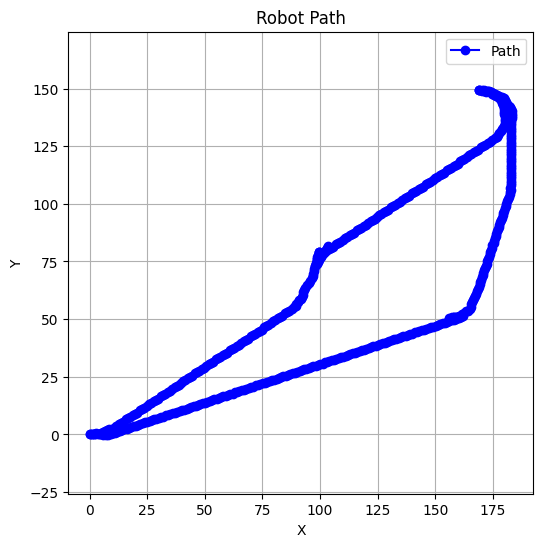

In [5]:

def generate_commands(
    path,
    angle_epsilon=0.05,
    reverse_threshold=math.pi/2,
    distance_epsilon=1e-3
):

    if not path:
        return []

    # Generate uncompressed commands first
    raw_commands = []
    prev_x, prev_y, prev_angle = path[0]

    for i in range(1, len(path)):
        x, y, angle = path[i]

        # Compute distance and angle change from the last waypoint
        dx = x - prev_x
        dy = y - prev_y
        distance = math.sqrt(dx*dx + dy*dy)

        angle_change = angle - prev_angle

        # Normalize angle to (-pi, pi) to get the smallest turn
        if angle_change > math.pi:
            angle_change -= 2 * math.pi
        elif angle_change < -math.pi:
            angle_change += 2 * math.pi

        # Skip tiny rotations
        net_rotation = 0.0 if abs(angle_change) < angle_epsilon else angle_change

        # If rotation is large, do reverse-turn-move
        if abs(net_rotation) > reverse_threshold:
            half_dist = distance / 2.0
            # Reverse half if significant
            if half_dist > distance_epsilon:
                raw_commands.append(f"REVERSE {half_dist:.4f} units")
            raw_commands.append(f"TURN {net_rotation:.4f} radians")
            # Move the remaining half
            if half_dist > distance_epsilon:
                raw_commands.append(f"MOVE {half_dist:.4f} units")
        else:
            # For smaller turns, do a standard turn (if needed)
            if abs(net_rotation) >= angle_epsilon:
                raw_commands.append(f"TURN {net_rotation:.4f} radians")

            # Move forward if distance is non-trivial
            if distance > distance_epsilon:
                raw_commands.append(f"MOVE {distance:.4f} units")

        # Update the last waypoint
        prev_x, prev_y, prev_angle = x, y, angle

    # Compress same-type commands
    return compress_commands(raw_commands, distance_epsilon, angle_epsilon)

def compress_commands(command_list, distance_epsilon=1e-3, angle_epsilon=1e-3):

    if not command_list:
        return []

    compressed = []
    current_type = None
    current_sum = 0.0

    def flush_command():
        nonlocal current_type, current_sum
        if current_type is None:
            return
        if current_type == 'TURN':
            # Skip if angle is negligible
            if abs(current_sum) >= angle_epsilon:
                compressed.append(f"TURN {current_sum:.4f} radians")
        else:  # MOVE or REVERSE
            if abs(current_sum) >= distance_epsilon:
                compressed.append(f"{current_type} {current_sum:.4f} units")
        current_type = None
        current_sum = 0.0

    for cmd in command_list:
        parts = cmd.split()
        cmd_type = parts[0]      
        value_str = parts[1]
        val = float(value_str)


        if cmd_type == current_type:
            current_sum += val
        else:
            flush_command()
            current_type = cmd_type
            current_sum = val

    flush_command()

    return compressed

def plot_path(path, arrow_length=0.5, arrow_interval=5):

    if not path:
        print("No path to plot.")
        return

    x_coords = [pt[0] for pt in path]
    y_coords = [pt[1] for pt in path]

    # Create a new figure and plot
    plt.figure(figsize=(6,6))
    plt.plot(x_coords, y_coords, 'bo-', label='Path')

    # Draw orientation arrows at the specified interval
    for i, (x, y, theta) in enumerate(path):
        # Only draw arrow if i % arrow_interval == 0 or it's the last waypoint
        if (i % arrow_interval == 0) or (i == len(path) - 1):
            dx = arrow_length * math.cos(theta)
            dy = arrow_length * math.sin(theta)
            plt.arrow(
                x, y, dx, dy,
                head_width=arrow_length * 0.2,
                head_length=arrow_length * 0.2,
                fc='r', ec='r'
            )

    plt.axis('equal')
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Robot Path')
    plt.legend()
    plt.show()



commands = generate_commands(path)
for c in commands:
    print(c)

plot_path(path, arrow_length=0.5, arrow_interval=10)
